# Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
path = os.path.join(os.path.dirname(os.getcwd()), "data")
sys.path.insert(0, ROOT)
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* select_by_mz(s, mz_from=0, mz_to=1000)
* select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1.0)

In [2]:
from matchms.importing import load_from_msp

spectrums = [s for s in load_from_msp(msp_file)]
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

spectrums = [apply_my_filters(s) for s in spectrums]

spectrums = [s for s in spectrums if s is not None]

#Filter spectra with peak intensities length equals or less than zero
spectrums = [s for s in spectrums if len(s.peaks.intensities) > 0]

print("Number of Spectra:", len(spectrums))

Number of Spectra: 14844


## Converting Spectrum objects to Spectrum Documents

In [4]:
from spec2vec import SpectrumDocument

reference_documents = [SpectrumDocument(s) for s in spectrums]

print(len(reference_documents))

14844


## Training the word2vec model

Data used for training the model:\
**Iterarions=10, 20, 30**\
**Workers=2**

Once the model is trained the file "references.model" is stored for further use in the score calculation

In [5]:
from spec2vec.model_building import train_new_word2vec_model
    
model_file = os.path.join(path, "testing-references.model")
model = train_new_word2vec_model(documents=reference_documents, filename=model_file, 
                                 size=650, iterations=[10, 20, 30],
                                 workers=2, progress_logger=False)

The value of size is set from 300 (default) to 650
The value of workers is set from 4 (default) to 2
Saving model with name: /Volumes/easystore/spec2vec_gcms_data_analysis/data/testing-references_iter_10.model
Saving model with name: /Volumes/easystore/spec2vec_gcms_data_analysis/data/testing-references_iter_20.model
Saving model with name: /Volumes/easystore/spec2vec_gcms_data_analysis/data/testing-references.model


## Setting the query data

All Spectra in the Monna file will be used to try to find them using the Spec2VecParallel method

In [6]:
query_documents = reference_documents.copy()

### Ref and QuerySpectrums Documents

In [7]:
print("Ref docs:", len(reference_documents), "Query docs:", len(query_documents))

Ref docs: 14844 Query docs: 14844


### Loading the model file to word2vec for the similarity function

Parameters for the similarity function:\
**intensity_weighting_power=0.5**\
**allowed_missing_percentage=5.0**

In [8]:
import gensim
from matchms import calculate_scores_parallel
from spec2vec import Spec2VecParallel

model = gensim.models.Word2Vec.load(model_file)
    
# Define similarity_function
spec2vec = Spec2VecParallel(model=model, intensity_weighting_power=0.5,
                            allowed_missing_percentage=5.0)

### Calculating the similarity of the reference and query documents using Spec2vec parallel method

For the calculation the same Spectrums are being used as reference and query

In [9]:
matrix_similarities_spec2vec = spec2vec(reference_documents, query_documents)

In [10]:
import numpy as np

# filename = os.path.join(path,'similarities_filter05_spec2vec_3iter_size650.npy')
# np.save(filename, scores_spec2vec)

In [11]:
filename = os.path.join(path, "gcms_similarities_filter05_morgan3_2048_dice.npy")
matrix_similarities_tanimoto = np.load(filename)

print("Matrix dimension", matrix_similarities_tanimoto.shape)

Matrix dimension (14844, 14844)


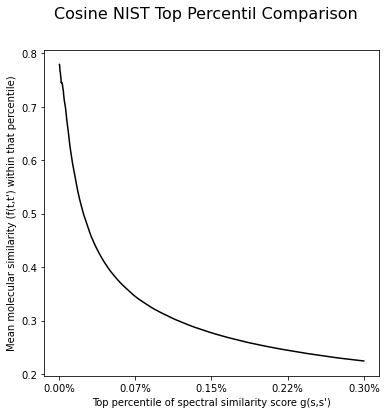

In [12]:
from custom_functions.plotting_functions import plot_precentile

show_top_percentile = 0.3

percentile_cosine_nist = plot_precentile(matrix_similarities_tanimoto, matrix_similarities_spec2vec, show_top_percentile=show_top_percentile, title="Cosine NIST Top Percentil Comparison", ignore_diagonal=True)
